# Project Solution Lab 2: 

# Problem: Predicting Credit Card Fraud 

## Introduction to business scenario
You work for a multinational bank. There has been a significant increase in the number of customers experiencing credit card fraud over the last few months. A major news outlet even recently published a story about the credit card fraud you and other banks are experiencing. 

As a response to this situation, you have been tasked to solve part of this problem by leveraging machine learning to identify fraudulent credit card transactions before they have a larger impact on your company. You have been given access to a dataset of past credit card transactions, which you can use to train a machine learning model to predict if transactions are fraudulent or not. 


## About this dataset
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred over the course of two days and includes examples of both fraudulent and legitimate transactions.

### Features
The dataset contains over 30 numerical features, most of which have undergone principal component analysis (PCA) transformations because of personal privacy issues with the data. The only features that have not been transformed with PCA are 'Time' and 'Amount'. The feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction amount. 'Class' is the response or target variable, and it takes a value of '1' in cases of fraud and '0' otherwise.

Features: 
`V1, V2, ... V28`: Principal components obtained with PCA

Non-PCA features:
- `Time`: Seconds elapsed between each transaction and the first transaction in the dataset, $T_x - t_0$
- `Amount`: Transaction amount; this feature can be used for example-dependent cost-sensitive learning 
- `Class`: Target variable where `Fraud = 1` and `Not Fraud = 0`

### Dataset attributions

Website: https://www.openml.org/d/1597

Authors: Andrea Dal Pozzolo, Olivier Caelen, and Gianluca Bontempi
Source: Credit card fraud detection - June 25, 2015
Official citation: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson, and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.

# Step 1: Problem formulation and data collection

Start this project off by writing a few sentences below that summarize the business problem and the business goal you're trying to achieve in this scenario. Include a business metric you would like your team to aspire toward. With that information defined, clearly write out the machine learning problem statement. Finally, add a comment or two about the type of machine learning this represents.

#### <span style="color: blue;">Project presentation: Include a summary of these details in your project presentations.</span>

### Read through a business scenario and:

### 1. Determine if and why ML is an appropriate solution to deploy.
\# Write your answer here

### 2. Formulate the business problem, success metrics, and desired ML output.
\# Write your answer here

### 3. Identify the type of ML problem you’re dealing with.
\# Write your answer here

### 4. Analyze the appropriateness of the data you’re working with.
\# Write your answer here


### Setup

Now that we have decided where to focus our energy, let's set things up so you can start working on solving the problem.

**Note:** This notebook was created and tested on an `ml.m4.xlarge` notebook instance. 

Replace **`<LabBucketName>`** with the resource name that was provided with your lab account.

In [1]:
# Change the bucket according to your information
bucket = '<LabBucketName>'

In [1]:
%%capture

%pip install --upgrade boto3 -q
%matplotlib inline
%pip uninstall scikit-learn -y -q
%pip install imbalanced-learn==0.7.0 -q
%pip install imblearn -q

ModuleNotFoundError: No module named 'matplotlib'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set()

### Downloading the dataset

In [4]:
# Check whether the file is already in the desired path or if it needs to be downloaded
import os
import subprocess
base_path = '/home/ec2-user/SageMaker/project/data/FraudDetection'
file_path = '/fraud.csv'

if not os.path.isfile(base_path + file_path):
    subprocess.run(['mkdir', '-p', base_path])
    subprocess.run(['aws', 's3', 'cp', 
                    's3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/credit_card_project/', 
                    base_path,'--recursive'])
else:
    print('File already downloaded!')

download: s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/credit_card_project/fraud.csv to ../project/data/FraudDetection/fraud.csv


# Step 2: Data preprocessing and visualization 
In this data preprocessing phase, you should take the opportunity to explore and visualize your data to better understand it. First, import the necessary libraries and read the data into a Pandas dataframe. After that, explore your data. Look for the shape of the dataset and explore your columns and the types of columns you're working with (numerical, categorical). Consider performing basic statistics on the features to get a sense of feature means and ranges. Take a close look at your target column and determine its distribution.

### Specific questions to consider
1. What can you deduce from the basic statistics you ran on the features? 

2. What can you deduce from the distributions of the target classes?

3. Is there anything else you deduced from exploring the data?

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and other similar questions in your project presentations.</span>

Read the CSV data into a Pandas dataframe. You can use the built-in Python `read_csv` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)).

In [5]:
df = pd.read_csv('/home/ec2-user/SageMaker/project/data/FraudDetection/fraud.csv')

Check the dataframe by printing the first 5 rows of the dataset.  

**Hint**: Use the `<dataframe>.head()` function.

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [7]:
# The class has a weird string instead of a boolean or numbers 0 and 1, so convert it to 0 and 1 

mapped_class = {"'0'": 0, "'1'": 1}
df['Class'] = df['Class'].map(lambda x: mapped_class[x])

In [8]:
# Check if that worked

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Question**: What is the shape of your dataset?  

**Hint**: To check the shape of a dataframe, use the `<dataframe>.shape` function.

In [9]:
df.shape

(284807, 31)

**Task**: Validate all the columns in the dataset and see that they are what you read above: `V1-V28`, `Time`, `Amount`, and `Class`.  

**Hint**: Use `<dataframe>.columns` to check the columns in your dataframe.

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

**Question**: What can you find out about the column types and the null values? How many columns are numerical or categorical? 

**Hint**: Use the `info()` function to check.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Question**: Perform basic statistics using the Pandas library and `Describe` function. What is the mean and standard deviation for the `amount` feature? What can you deduce from those numbers?

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Answer:** Using the `describe` function, you can find some salient features of the dataset. 

- The mean amount for this dataset is \\$88 but this also consists of a lot of not fraud examples. But the max amount goes up to \\$25.
- The standard deviation for the Amount column is \\$250.

**Question**: What is the mean, standard deviation, and maximum for the `amount` for the records that are fraud?  

**Hint**: Use the built-in `mean()`, `std()`, and `max()` functions in dataframes.

In [13]:
print("Fraud Statistics")

avg_amt = df[df['Class']== 1]['Amount'].mean()
std_dev = df[df['Class']== 1]['Amount'].std()
max_amt = df[df['Class']== 1]['Amount'].max()

print(f"The average amount is {avg_amt}")
print(f"The std deviation for amount is {std_dev}")
print(f"The max amount is {max_amt}")

Fraud Statistics
The average amount is 122.21132113821139
The std deviation for amount is 256.68328829771207
The max amount is 2125.87


Now look at the target variable, `Class`. First, you can find out what the distribution is for it.
 
**Question**: What is the distribution of the classes?  

**Hint**: Use `<dataframe>['column_name'].value_counts()` to check the distribution.

In [14]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

**Question**: What can you deduce from the distribution of the classes?

**Answer:** The target variable distribution is very skewed. There are a lot of **not fraud** examples and very few **fraud** examples. 

**Question**: What's the ratio of classes for 0s to the total number of records?

In [15]:
284315/(284315+492)

0.9982725143693799

## Visualize your data
If you haven't done so in the above, you can use the space below to further visualize some of your data. Look specifically at the distribution of features like `Amount` and `Time`, and also calculate the linear correlations between the features in the dataset. 

### Specific questions to consider
1. After looking at the distributions of features like `Amount` and `Time`, to what extend might those features help your model? Is there anything you can deduce from those distributions that might be helpful in better understanding your data?

2. Do the distributions of features like `Amount` and `Time` differ when you are looking only at data that is labeled as fraud?

3. Are there any features in your dataset that are strongly correlated? If so, what would be your next steps?

Use the cells below to visualize your data and answer these and other questions that might be of interest to you. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Include a summary of your answers to these and similar questions in your project presentations.</span>

Start with a simple scatter plot. Plot V1 vs. V2. For more information about plotting a scatter plot, see the [Matplotlib documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html).

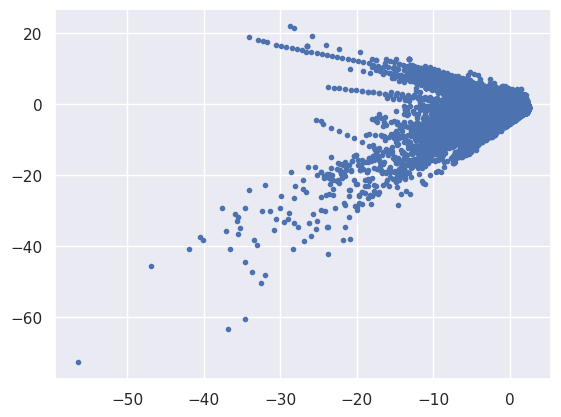

In [16]:
plt.plot(df['V1'], df['V2'],'.')

Look at a distribution of some of the features. Use `sns.displot()` to find the distribution of the individual features such as `Amount` and `Time`.

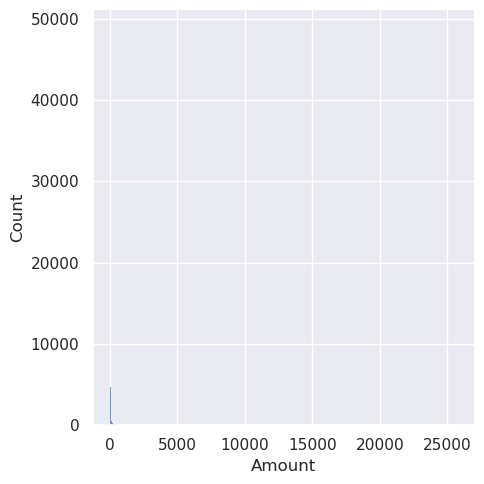

In [17]:
sns.displot(df['Amount'])

**Question**: Would the `Time` feature help you in any way? Look at the distribution again. What can you deduce from the scatter plot?

**Answer:** This distribution plot tells us the same thing that we saw in the `describe` function above. Most of the values are closer to \\$100, but there are some that are bigger.

Plot a histogram and Kernel density estimation (KDE).

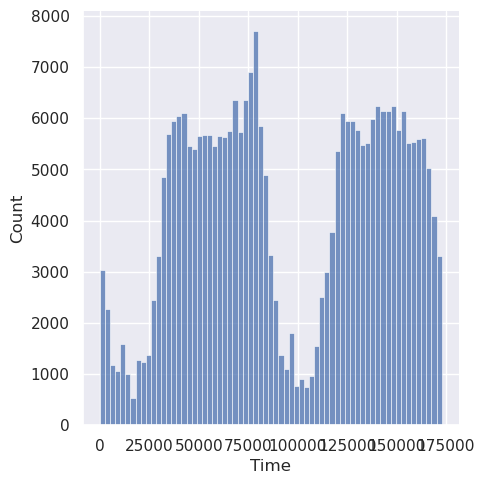

In [18]:
sns.displot(df['Time'])

The time distribution also confirms what the dataset told us. The data includes two days' worth of data where there are more credit card transactions during the day and fewer at night.

**Question**: What does this distribution look like for fraud cases for the `Amount` column?

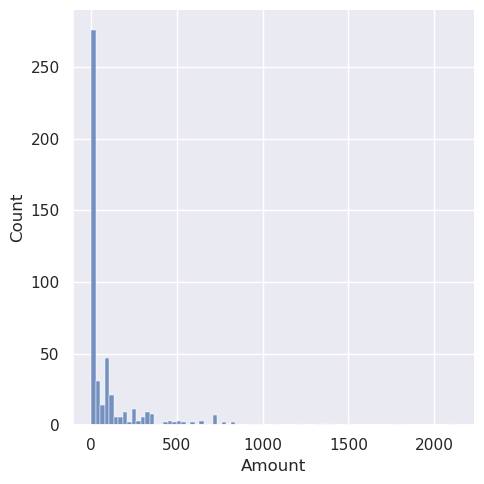

In [19]:
sns.displot(df[df['Class'] == 1]['Amount'])

Now let's look at a distribution using a Seaborn function called `pairplot`. `pairplot` creates a grid of scatterplots, such that each feature in the dataset is used once as the X-axis and once as the Y-axis. The diagonal of this grid shows a distribution of the data for that feature. 

Look at `V1`, `V2`, `V2`, `V4`, and `Class` pairplots. What do you see in the plots? Can you differentiate the fraud and not fraud from these features?  

**Hint**: Create a new dataframe with columns `V1`, `V2`, `V4`, and `Class`.

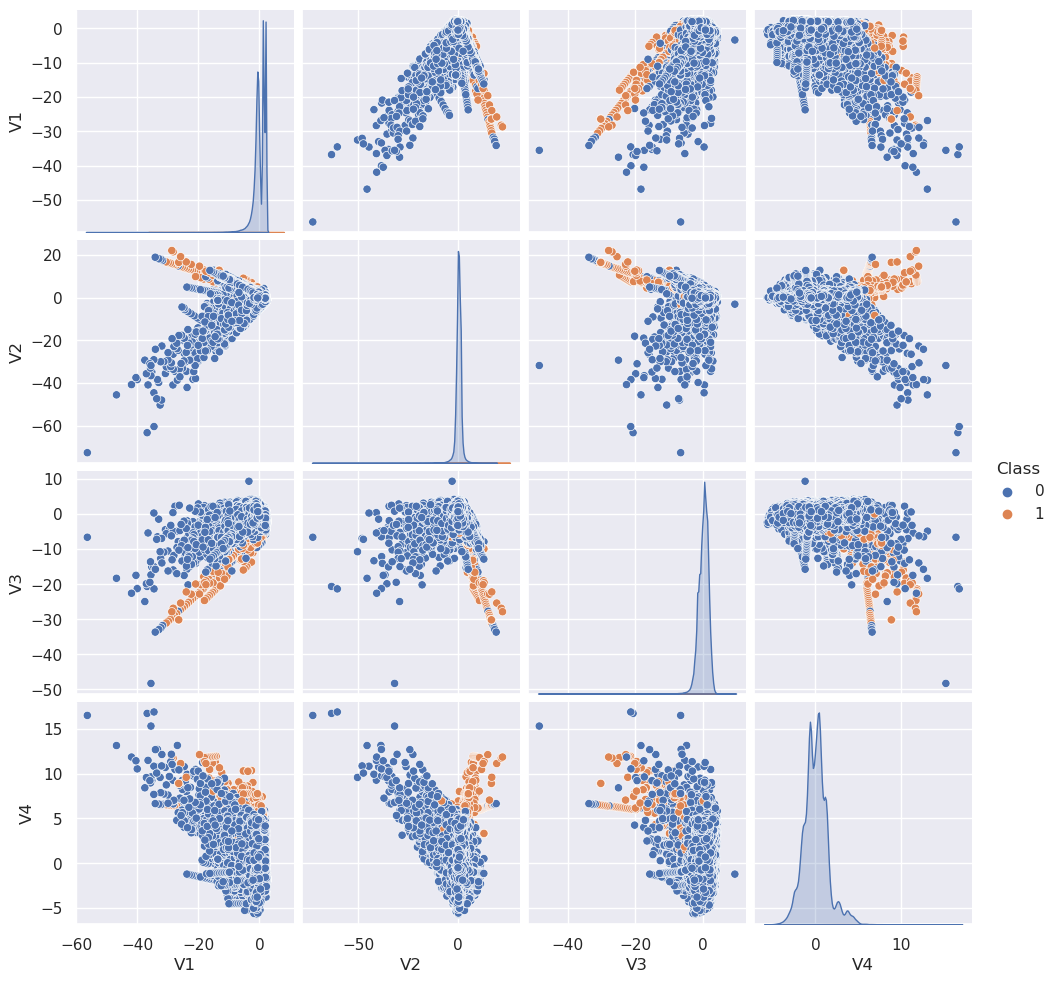

In [20]:
new_df = df[['V1', 'V2', 'V3', 'V4','Class']]
sns.pairplot(new_df, hue="Class")

You can see for the smaller subset of the features that we used, there is a way to differentiate the fraud and not fraud, but it's not easy to separate it based on any one feature.

Now, let's look at how these features interact with each other. Use the Pandas `corr` function to calculate the linear correlations between the features of the dataset. It is always easier to visualize the correlation. Plot the correlation using the Seaborn heatmap (`sns.heatmap`) function with the `annot` flag set to `True`.

<AxesSubplot: >

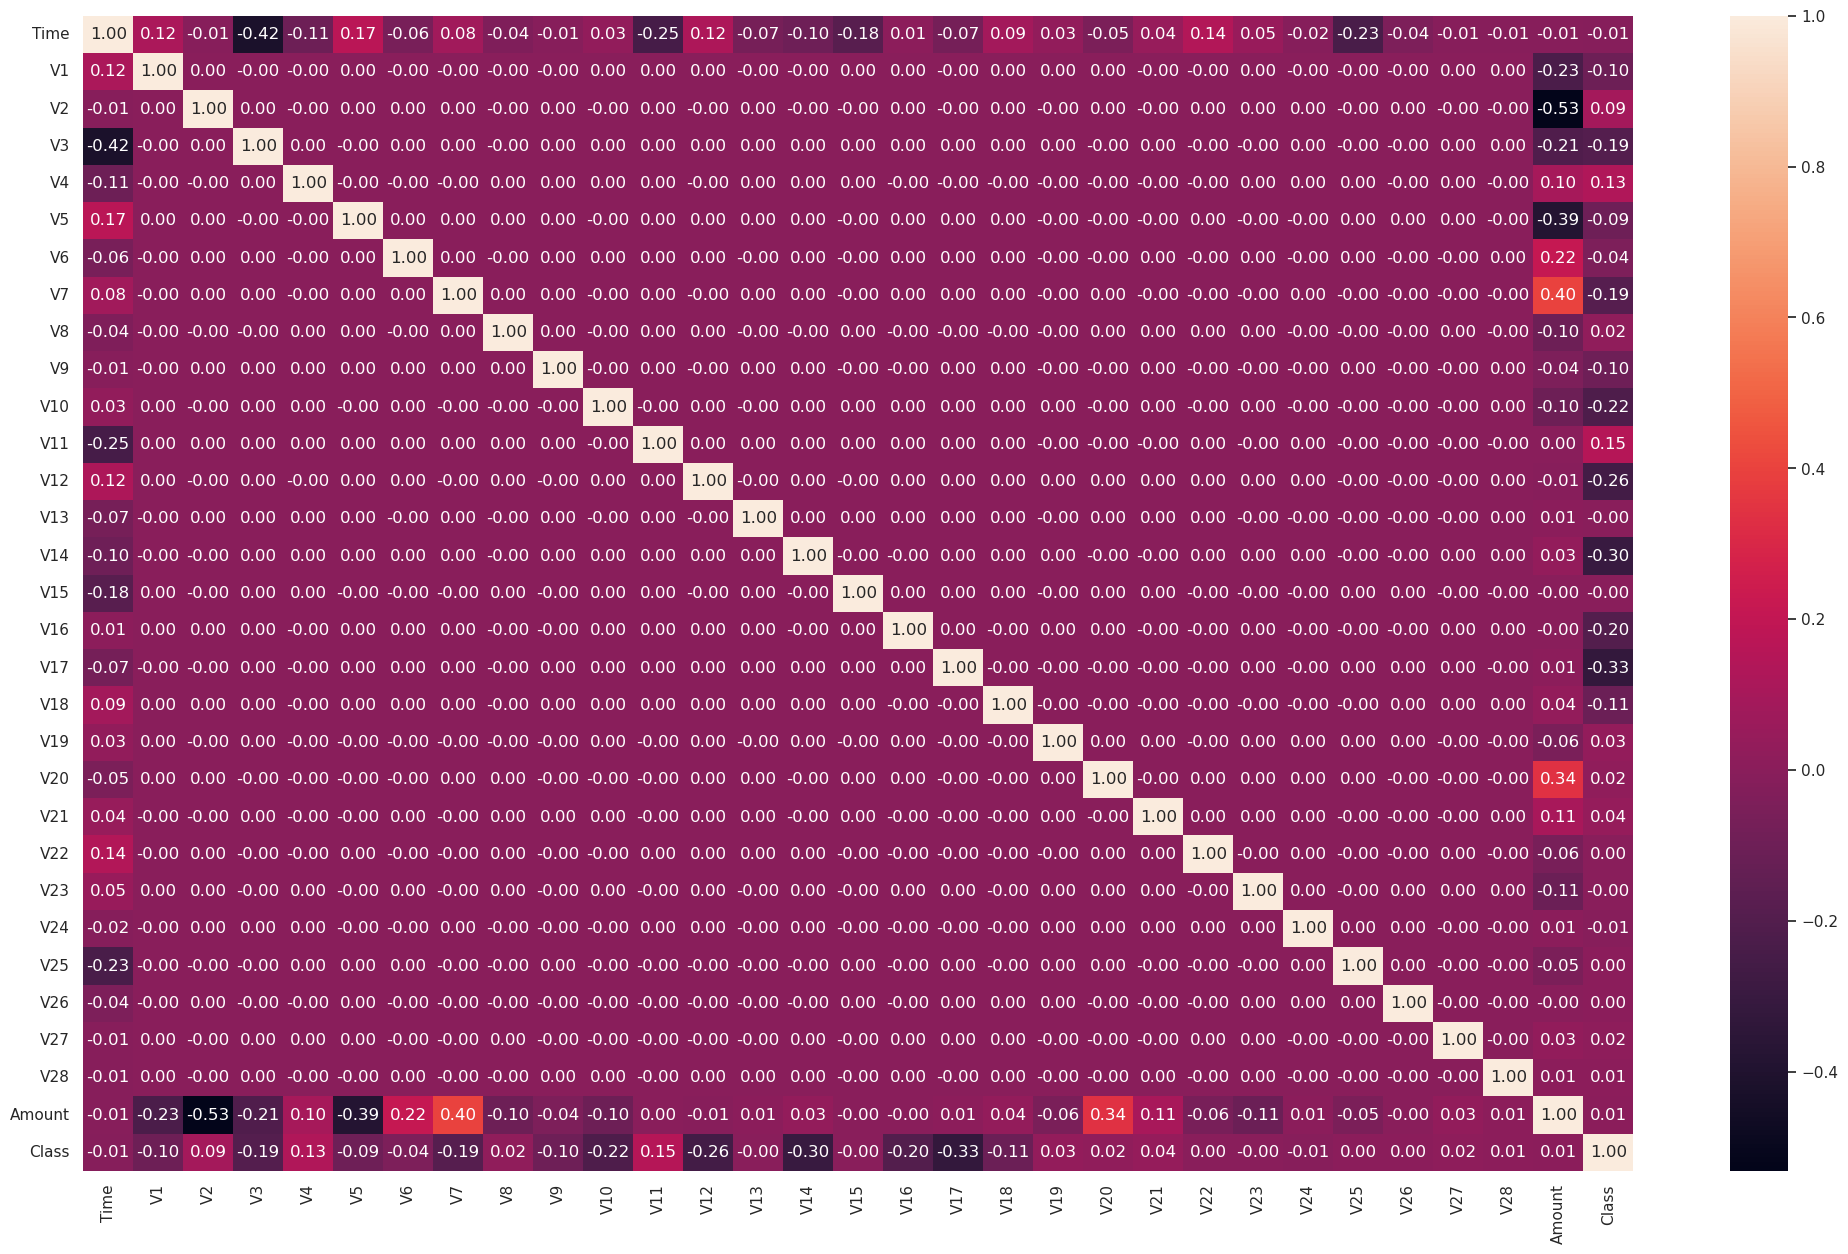

In [21]:
plt.figure(figsize = (25,15))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True,fmt=".2f")

**Question**: For correlated features, you should remove one of them before model training. Do you see any features that you can remove?

**Answer**: There aren't any correlated features to be removed.

# Project Solution Lab 3: 

# Step 3: Model training and evaluation

There are some preliminary steps that you have to include when converting the dataset from a DataFrame to a format that a machine learning algorithm can use. For Amazon SageMaker, here are the steps you need to take:

1. Split the data into `train_data`, `validation_data`, and `test_data` using `sklearn.model_selection.train_test_split`.    
2. Convert the dataset to an appropriate file format that the Amazon SageMaker training job can use. This can be either a CSV file or record protobuf. For more information, see [Common Data Formats for Training](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html).    
3. Upload the data to your Amazon S3 bucket.

Use the following cells to complete these steps. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Take note of the key decisions you've made in this phase in your project presentations.</span>

- The Amazon Simple Storage Service (Amazon S3) bucket and prefix(?) that you want to use for training and model data. This should be within the same Region as the Notebook Instance, training, and hosting.
- The AWS Identity and Access Management (IAM) role [Amazon Resource Name (ARN)](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) used to give training and hosting access to your data. See the documentation for how to create these.

**Note:** If more than one role is required for notebook instances, training, and/or hosting, replace the `get_execution_role()` call with the appropriate full IAM role ARN string(s).

In [22]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import image_uris
from sagemaker.amazon.amazon_estimator import RecordSet

In [23]:
# Instantiate an Amazon SageMaker session
sess = sagemaker.Session()

# Get the Amazon SageMaker role 
role = get_execution_role()

# Get the image URI for the container that includes the linear learner algorithm
container = image_uris.retrieve('linear-learner',boto3.Session().region_name)

print(f'Session {sess}')
print(f'The role is {role}')
print(f'The container is {role} in the {boto3.Session().region_name} region')

Session <sagemaker.session.Session object at 0x7fdc82288b80>
The role is arn:aws:iam::431225565897:role/LabStack-mccuisp-mxgt8GHY-SageMakerNotebookInstanc-428Y6ZO9LECS
The container is arn:aws:iam::431225565897:role/LabStack-mccuisp-mxgt8GHY-SageMakerNotebookInstanc-428Y6ZO9LECS in the us-east-1 region


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

def create_training_sets(data):
    """
    Convert data frame to train, validation and test
    params:
        data: The dataframe with the dataset to be split
    Returns:
        train_features: Training feature dataset
        test_features: Test feature dataset 
        train_labels: Labels for the training dataset
        test_labels: Labels for the test dataset
        val_features: Validation feature dataset
        val_labels: Labels for the validation dataset
    """
    # Extract the target variable from the dataframe and convert the type to float32
    ys = np.array(data["Class"]).astype("float32")
    
    # Drop all the unwanted columns including the target column
    drop_list = ["Class","Time"]
    
    # Drop the columns from the drop_list and convert the data into a NumPy array of type float32
    xs = np.array(data.drop(drop_list, axis=1)).astype("float32")
    
    np.random.seed(0)
    
    # Use the sklearn function train_test_split to split the dataset in the ratio train 80% and test 20%
    train_features, test_features, \
    train_labels, test_labels = train_test_split(xs, ys, test_size=0.2, stratify=ys)
    
    # Use the sklearn function again to split the test dataset into 50% validation and 50% test
    val_features, test_features, \
    val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5, stratify=test_labels)
    
    return train_features, test_features, train_labels, test_labels, val_features, val_labels

In [25]:
# Use the function to create your datasets
train_features, test_features, train_labels, test_labels, val_features, val_labels = create_training_sets(df)

print(f"Length of train_features is: {train_features.shape}")
print(f"Length of train_labels is: {train_labels.shape}")
print(f"Length of val_features is: {val_features.shape}")
print(f"Length of val_labels is: {val_labels.shape}")
print(f"Length of test_features is: {test_features.shape}")
print(f"Length of test_labels is: {test_labels.shape}")

Length of train_features is: (227845, 29)
Length of train_labels is: (227845,)
Length of val_features is: (28481, 29)
Length of val_labels is: (28481,)
Length of test_features is: (28481, 29)
Length of test_labels is: (28481,)


In [26]:
print('Train class split')
tr_hist = np.histogram(train_labels, bins=2)[0]
print(tr_hist)
print(tr_hist[1]*1. / (tr_hist[0] + tr_hist[1]))

print('\nValidation class split')
val_hist = np.histogram(val_labels, bins=2)[0]
print(val_hist)
print(val_hist[1]*1. / (val_hist[0] + val_hist[1]))

print('\nTest class split')
test_hist = np.histogram(test_labels, bins=2)[0]
print(test_hist)
print(test_hist[1]*1. / (test_hist[0] + test_hist[1]))

Train class split
[227451    394]
0.001729245759178389

Validation class split
[28432    49]
0.0017204452090867595

Test class split
[28432    49]
0.0017204452090867595


### Model training

Lets start by instantiating the LinearLearner estimator with `predictor_type='binary_classifier'` parameter with one ml.m4.xlarge instance.

In [27]:
import sagemaker
from sagemaker.amazon.amazon_estimator import RecordSet

# Instantiate the LinearLearner estimator object
num_classes = len(pd.unique(train_labels))

# Instantiate the LinearLearner estimator 'binary classifier' object with one ml.m4.xlarge instance
linear = sagemaker.LinearLearner(role=sagemaker.get_execution_role(),
                                               instance_count=1,
                                               instance_type='ml.m4.xlarge',
                                               predictor_type='binary_classifier')

Linear learner accepts training data in protobuf or CSV content types, and accepts inference requests in protobuf, CSV, or JSON content types. Training data has features and ground-truth labels, while the data in an inference request has only features. In a production pipeline, it is recommended to convert the data to the Amazon SageMaker protobuf format and store it in Amazon S3. However, to get up and running quickly, AWS provides the convenient method `record_set` for converting and uploading when the dataset is small enough to fit in local memory. It accepts NumPy arrays like the ones you already have, so let's use it here. The `RecordSet` object will keep track of the temporary Amazon S3 location of your data. Use the `estimator.record_set` function to create train, validation, and test records. Then, use the `estimator.fit` function to start your training job.

In [28]:
### Create train, val, test records
train_records = linear.record_set(train_features, train_labels, channel='train')
val_records = linear.record_set(val_features, val_labels, channel='validation')
test_records = linear.record_set(test_features, test_labels, channel='test')

Now, lets train your model on the dataset that you just uplaoded.

In [29]:
### Fit the classifier
linear.fit([train_records,val_records], wait=True, logs='All')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: linear-learner-2023-01-24-19-20-49-443


2023-01-24 19:20:50 Starting - Starting the training job...
2023-01-24 19:21:16 Starting - Preparing the instances for training.........
2023-01-24 19:22:32 Downloading - Downloading input data...
2023-01-24 19:23:07 Training - Downloading the training image......
2023-01-24 19:24:08 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/24/2023 19:24:29 INFO 140092044281664] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss

## Model evaluation
In this section, you'll evaluate your trained model. First, use the `estimator.deploy` function with `initial_instance_count= 1` and `instance_type= 'ml.m4.xlarge'` to deploy your model on Amazon SageMaker.

In [30]:
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: linear-learner-2023-01-24-19-27-49-973
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-01-24-19-27-49-973
INFO:sagemaker:Creating endpoint with name linear-learner-2023-01-24-19-27-49-973


----------!

Now that you have a hosted endpoint running, you can make real-time predictions from the model easily by making an http POST request. But first, you'll need to set up serializers and deserializers for passing your `test_features` NumPy arrays to the model behind the endpoint. You will also calculate the confusion matrix for your model to evaluate how it has done on your test data visually.

In [31]:
from sklearn.metrics import accuracy_score,precision_score, recall_score
#from sagemaker.predictor import csv_serializer, json_deserializer,numpy_deserializer
#from sagemaker.predictor import csv_deserializer

def predict_batches(model, features, labels, split=200):
    """
    Predict datapoints in batches specified by the split. 
    The data will be split into <split> parts and model.predict is called 
    on each part
    Arguments:
        model: The model that you will use to call predict function
        features: The dataset to predict on
        labels: The true value of the records
        split: Number of parts to split the data into
    Returns:
        None
    """
    
    split_array = np.array_split(features, split)
    predictions = []
    for array in split_array:
        predictions +=  model.predict(array)

    # preds = np.array([p['predicted_label'] for p in predictions])
    preds = [i.label['predicted_label'].float32_tensor.values[0] for i in predictions]
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    print(f'Accuracy: {accuracy}')
    
    # Calculate precision
    precision = precision_score(labels, preds)
    print(f'Precision: {precision}')
    
    # Calculate recall
    recall = recall_score(labels, preds)
    print(f'Recall: {recall}')
    
    confusion_matrix = pd.crosstab(index=labels, columns=np.round(preds), rownames=['True'], colnames=['predictions']).astype(int)
    plt.figure(figsize = (5,5))
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix') 
    

Now that your endpoint is 'InService', evaluate how your model performs on the test set. Compare that test set performance to the performance on the training set. 

### Key questions to consider:
1. How does your model's performance on the test set compare to the training set? What can you deduce from this comparison? 

2. Are there obvious differences between the outcomes of metrics like accuracy, precision, and recall? If so, why might you be seeing those differences? 

3. Given your business situation and goals, which metric(s) is most important for you to consider here? Why?

4. Is the outcome for the metric(s) you consider most important sufficient for what you need from a business standpoint? If not, what are some things you might change in your next iteration (in the feature engineering section, which is coming up next)? 

Use the cells below to answer these and other questions. Insert and delete cells where needed.

#### <span style="color: blue;">Project presentation: Record answers to these and other similar questions you might answer in this section in your project presentations. Record key details and decisions you've made in your project presentations.</span>

Accuracy: 0.9994382219725431
Precision: 0.8666666666666667
Recall: 0.7959183673469388


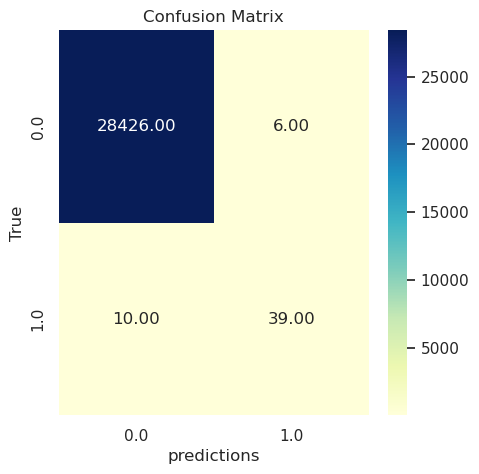

In [32]:
predict_batches(linear_predictor, test_features, test_labels)

Similar to the test set, you can also look at the metrics for the training set. Keep in mind that those are also shown to you above in the logs.

In [33]:
#predict_batches(linear_predictor, train_features, train_labels)

In [34]:
# Delete inference endpoint
sagemaker.Session().delete_endpoint(linear_predictor.endpoint_name)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-01-24-19-27-49-973
